In [1]:
# Data downloading and extraction
import os
import torch
from torchvision import transforms
from kaggle.api.kaggle_api_extended import KaggleApi

# Set the dataset name and download directory
dataset = "veeralakrishna/butterfly-dataset"
download_dir = "dataset"

# Initialize Kaggle API
api = KaggleApi()
api.authenticate()

# Create the download directory if it does not exist
if not os.path.exists(download_dir):
    os.makedirs(download_dir)

# Download the dataset
print(f"Downloading {dataset} to {download_dir}...")
api.dataset_download_files(dataset, path=download_dir, unzip=True)
print(f"Dataset downloaded and unzipped to {download_dir}.")


Dataset URL: https://www.kaggle.com/datasets/veeralakrishna/butterfly-dataset
Dataset downloaded and unzipped to dataset.


In [2]:
# test the dataloader
from torch.utils.data import DataLoader
from data_loader import ButterflyDataset

train_dataset, val_dataset = ButterflyDataset.generate_datasets()

print(f"Train dataset size: {len(train_dataset)}")
print(f"Validation dataset size: {len(val_dataset)}")

print(f"Shape of the first image: {train_dataset[0][0].shape}")
print(f"Shape of the first segmentation: {train_dataset[0][1].shape}")
print(f"label of first image: {train_dataset[0][2]}")

Train dataset size: 665
Validation dataset size: 167
Shape of the first image: torch.Size([3, 128, 128])
Shape of the first segmentation: torch.Size([1, 128, 128])
label of first image: 0


In [3]:
# view the model
from models import MLP
from torchsummary import summary

summary(MLP(), (3, 128, 128))

model = MLP()
print(f" the model looks like: {model}")

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                [-1, 49152]               0
            Linear-2                  [-1, 256]      12,583,168
              ReLU-3                  [-1, 256]               0
           Dropout-4                  [-1, 256]               0
            Linear-5                  [-1, 256]          65,792
              ReLU-6                  [-1, 256]               0
             Block-7                  [-1, 256]               0
            Linear-8                  [-1, 256]          65,792
              ReLU-9                  [-1, 256]               0
            Block-10                  [-1, 256]               0
           Linear-11                   [-1, 10]           2,570
Total params: 12,717,322
Trainable params: 12,717,322
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.19
Fo

In [4]:
# Build datasets for training and validation
from torch.utils.data import DataLoader
from data_loader import ButterflyDataset
from torch.utils.data import random_split

# Define transformations - resize to 128x128 and convert to tensor
image_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor()
])

segmentation_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor()
])

# Create the dataset
image_dir = "dataset/leedsbutterfly/images"
segmentation_dir = "dataset/leedsbutterfly/segmentations"

# Dataset is a list of tuples (image, segmentation, class)
dataset = ButterflyDataset(
    image_dir=image_dir, 
    segmentation_dir=segmentation_dir, 
    transform=image_transform, 
    seg_transform=segmentation_transform
)

# Calculate lengths for training and validation splits
split = 0.8
dataset_length = len(dataset)
train_length = int(split * dataset_length)
val_length = dataset_length - train_length


train_dataset, val_dataset = random_split(dataset, [train_length, val_length])


train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)


In [5]:
# some basic verification of the dataset
print(f"Training dataset length: {len(train_dataset)}")
print(f"Validation dataset length: {len(val_dataset)}")

for i in range(4):
    image, segmentation, label = train_dataset[i]
    print(f"Image shape: {image.shape}, Segmentation shape: {segmentation.shape}, Label: {label}")



Training dataset length: 665
Validation dataset length: 167
Image shape: torch.Size([3, 128, 128]), Segmentation shape: torch.Size([1, 128, 128]), Label: 4
Image shape: torch.Size([3, 128, 128]), Segmentation shape: torch.Size([1, 128, 128]), Label: 3
Image shape: torch.Size([3, 128, 128]), Segmentation shape: torch.Size([1, 128, 128]), Label: 1
Image shape: torch.Size([3, 128, 128]), Segmentation shape: torch.Size([1, 128, 128]), Label: 9


In [6]:
from collections import Counter

# Assuming train_dataset is your dataset instance
labels = [label.item() for _, _, label in train_dataset]

# Count unique classes
unique_classes = set(labels)
print("Number of unique classes:", len(unique_classes))
print("Unique classes:", unique_classes)

# (Optional) Frequency count
class_counts = Counter(labels)
print("Class frequencies:", class_counts)


AttributeError: 'int' object has no attribute 'item'

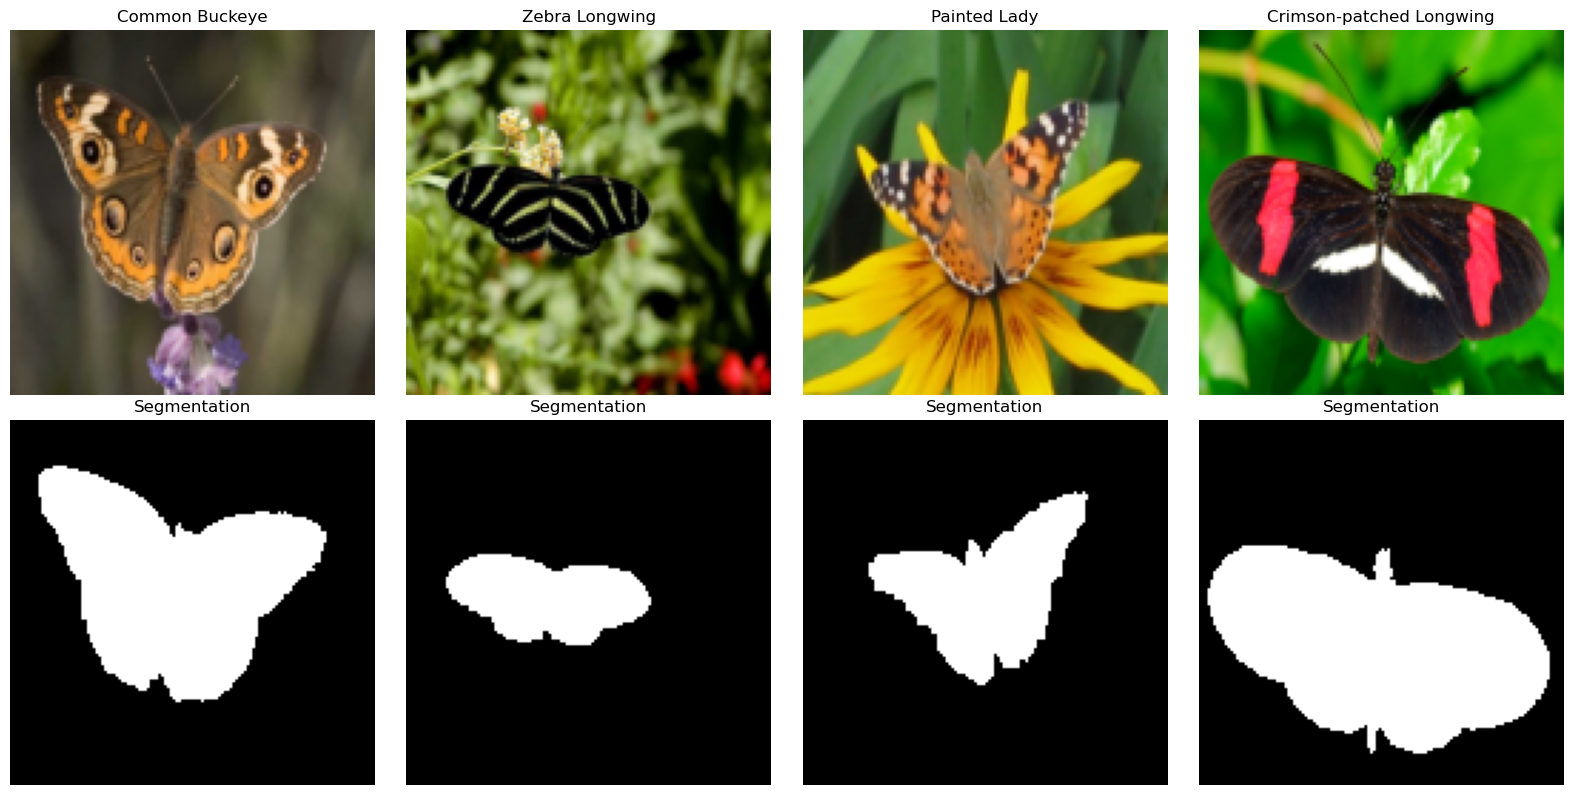

In [23]:
# Visualize a few of the images
import matplotlib.pyplot as plt

# Define the new titles for the images
image_titles = [
    "Common Buckeye", 
    "Zebra Longwing", 
    "Painted Lady", 
    "Crimson-patched Longwing"
]

fig, axs = plt.subplots(2, 4, figsize=(16, 8))

for i in range(4):
    image, segmentation, label = train_dataset[i+1]

    # Set the title with the new name
    axs[0, i].imshow(image.permute(1, 2, 0))
    axs[0, i].axis("off")
    axs[0, i].set_title(f"{image_titles[i]}")

    # Display the segmentation mask
    axs[1, i].imshow(segmentation.squeeze(), cmap="gray")
    axs[1, i].axis("off")
    axs[1, i].set_title(f"Segmentation")

# Save the figure as an image file
plt.tight_layout()
plt.savefig("image_segmentation.png", dpi=400)

In [28]:
for i in range(4):
    image, segmentation, label = train_dataset[i+1]
    print(f"segmentations: {segmentation}")

segmentations: tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]])
segmentations: tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]])
segmentations: tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]])
segmentations: tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0.,

In [6]:
# MLP training for classification
# the training occurs in the trainer.py file
# call the trainer 
from trainer import MLPTrainer
from models import MLP

# Create an instance of the MLP model
model = MLP()





In [7]:
# Define the loss function and optimizer
# For classification, we use cross entropy loss
loss_fn = torch.nn.CrossEntropyLoss()

optim = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [ ]:
# Run the model and perform training

for epoch in range(100):
    for imgs, labels in train_loader:
        pred = model(imgs)

        loss_value = loss_fn(pred, labels)
        optim.zero_grad()
        loss_value.backward()
        optim.step()
    
    print(f" epoch: {epoch}")
    print(f" loss: {loss_value}")



In [ ]:
# looks like the model is overfitting with very low loss on training set
# Compute accuracy on the validation set

correct = 0
total = 0
with torch.no_grad():
    for imgs, labels in val_loader:
        pred = model(imgs)
        _, predicted = torch.max(pred, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Accuracy: {correct / total}")



In [ ]:
# Compute accuracy using a different method
# check the accuracy
validation_images = torch.stack([im for im, _ in val_set], dim=0)
validation_label = torch.tensor([label for _, label in val_set])


pred_test = model(validation_images.view(-1, 3 * 128 * 128))
print(pred_test[:2])  # outputs logits, inputs into softmax

# code to compute the accuracy to distinguish between class 0 and 1
# boolean check on which predictions are correct, convert to float, take mean
print((pred_test.argmax(dim=1) == validation_label).float().mean())


# accuraccy is 50%, which is 5 times better than random chance of 1/10

In [ ]:
# Let's predict the class of a few images
# Load a few images from the validation set
images, labels = next(iter(val_loader))

# Predict the classes of the images
preds = model(images)
predicted_classes = preds.argmax(dim=1)

# Display the images and the predicted classes
fig, axs = plt.subplots(4, 4, figsize=(12, 12))

for i in range(16):
    ax = axs[i // 4, i % 4]
    ax.imshow(images[i].permute(1, 2, 0))  # Convert [3, 256, 256] to [256, 256, 3]
    ax.set_title(f"Predicted: {predicted_classes[i]}, Actual: {labels[i]}")
    ax.axis('off')

plt.tight_layout()
plt.show()
